In [57]:
# ! unzip -q '/content/drive/MyDrive/Landscape_dataset/landscape_ds.zip' -d './'



In [58]:
import os
import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

In [59]:
MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True


In [60]:
class LandscapeDataset(Dataset):
  def __init__(self, transform=None):
    self.dataroot = './landscape Images'
    self.images = os.listdir(f'{self.dataroot}/color')
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    # Get image paths
    img_path = self.images[idx]

    # Load the images
    color_img = read_image(f'{self.dataroot}/color/{img_path}')/255
    gray_img = read_image(f'{self.dataroot}/gray/{img_path}')/255

    if self.transform:
      color_img = self.transform(color_img)
      gray_img = self.transform(gray_img)

      return color_img, gray_img



In [61]:
transform = transforms.Compose([transforms.Resize((150, 150), antialias = False)])
dataset = LandscapeDataset(transform = transform)

train_set, test_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)



In [62]:

# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

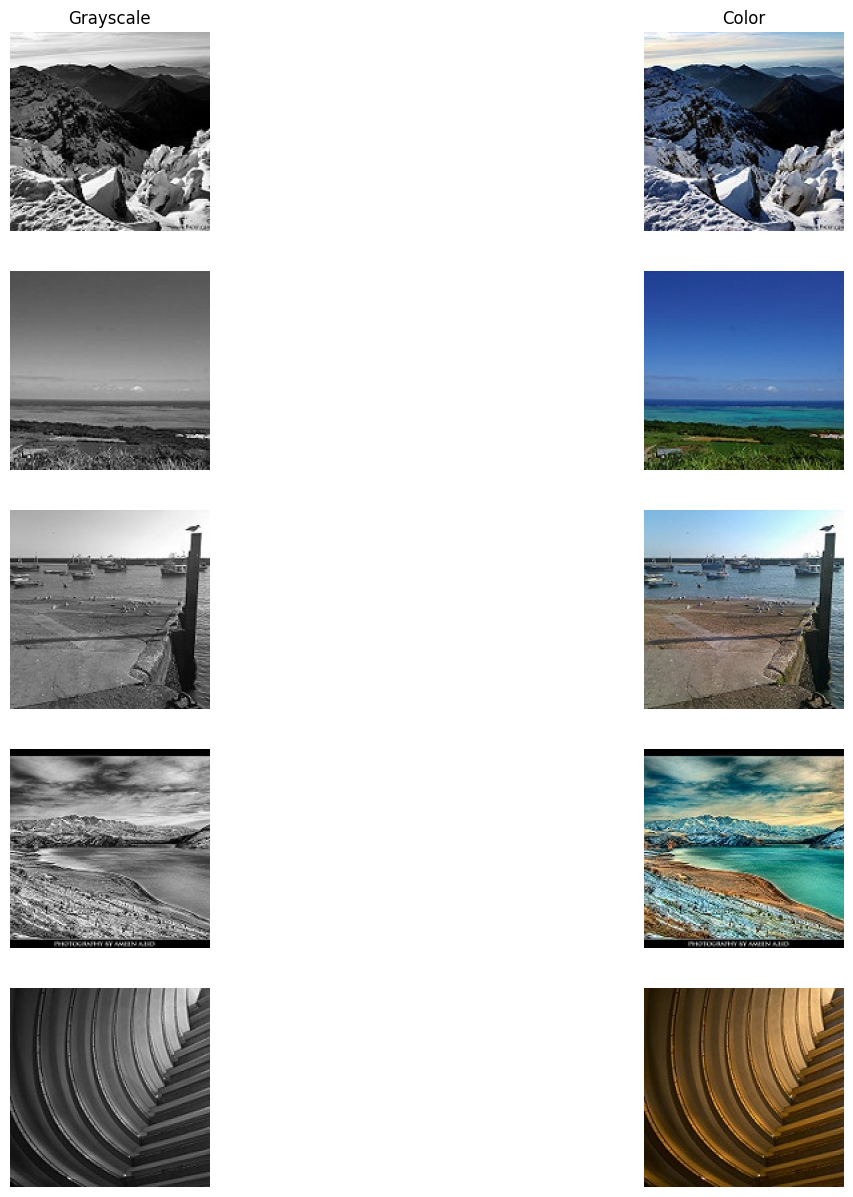

In [63]:
color, gray = next(iter(trainloader))
show_images(color, gray)

In [64]:
EPOCHS = 30
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(DEVICE)

cuda


In [65]:
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: Bx1x150x150
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x29
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Upsample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

In [66]:
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total number of trainable parameters {total_params}"

'Total number of trainable parameters 3470659'

In [67]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr =  LEARNING_RATE)

In [68]:
for epoch in range(EPOCHS):
  running_loss = 0.0
  for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total = len(trainloader)):
    color_img = color_img.to(DEVICE)
    gray_img = gray_img.to(DEVICE)

    predictions = model(gray_img)
    optimizer.zero_grad()
    loss = criterion(color_img, predictions)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f'Epoch {epoch+1} loss: {running_loss:.6f}')

torch.save(model, "color_autoencoder_full.pth")
torch.save(model.state_dict(), "color_autoencoder.pth")

  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 1 loss: 3.555472


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 2 loss: 1.689390


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 3 loss: 1.458688


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 4 loss: 1.368792


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 5 loss: 1.321145


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 6 loss: 1.268939


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 7 loss: 1.249645


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 8 loss: 1.225952


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 9 loss: 1.207281


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 10 loss: 1.187076


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 11 loss: 1.175763


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 12 loss: 1.157132


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 13 loss: 1.149806


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 14 loss: 1.137510


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 15 loss: 1.132741


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 16 loss: 1.104468


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 17 loss: 1.105917


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 18 loss: 1.093696


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 19 loss: 1.078437


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 20 loss: 1.062383


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 21 loss: 1.046625


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 22 loss: 1.029804


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 23 loss: 1.018064


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 24 loss: 0.994881


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 25 loss: 0.971165


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 26 loss: 0.952229


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 27 loss: 0.925022


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 28 loss: 0.906272


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 29 loss: 0.884668


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch 30 loss: 0.852032


In [69]:
# test on testing data

total_loss = 0
with torch.no_grad():
  for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total = len(testloader)):
    color_img = color_img.to(DEVICE)
    gray_img = gray_img.to(DEVICE)

    prediction = model(gray_img)

    prediction = model(gray_img)

    loss = criterion(prediction, color_img)
    total_loss += loss.item()

print(f'Test loss: {total_loss/len(testloader)}')

  0%|          | 0/45 [00:00<?, ?it/s]

Test loss: 0.006516772436185016


In [ ]:
# Visualize some predictions
def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(5, 3, figsize=(7, 7))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()

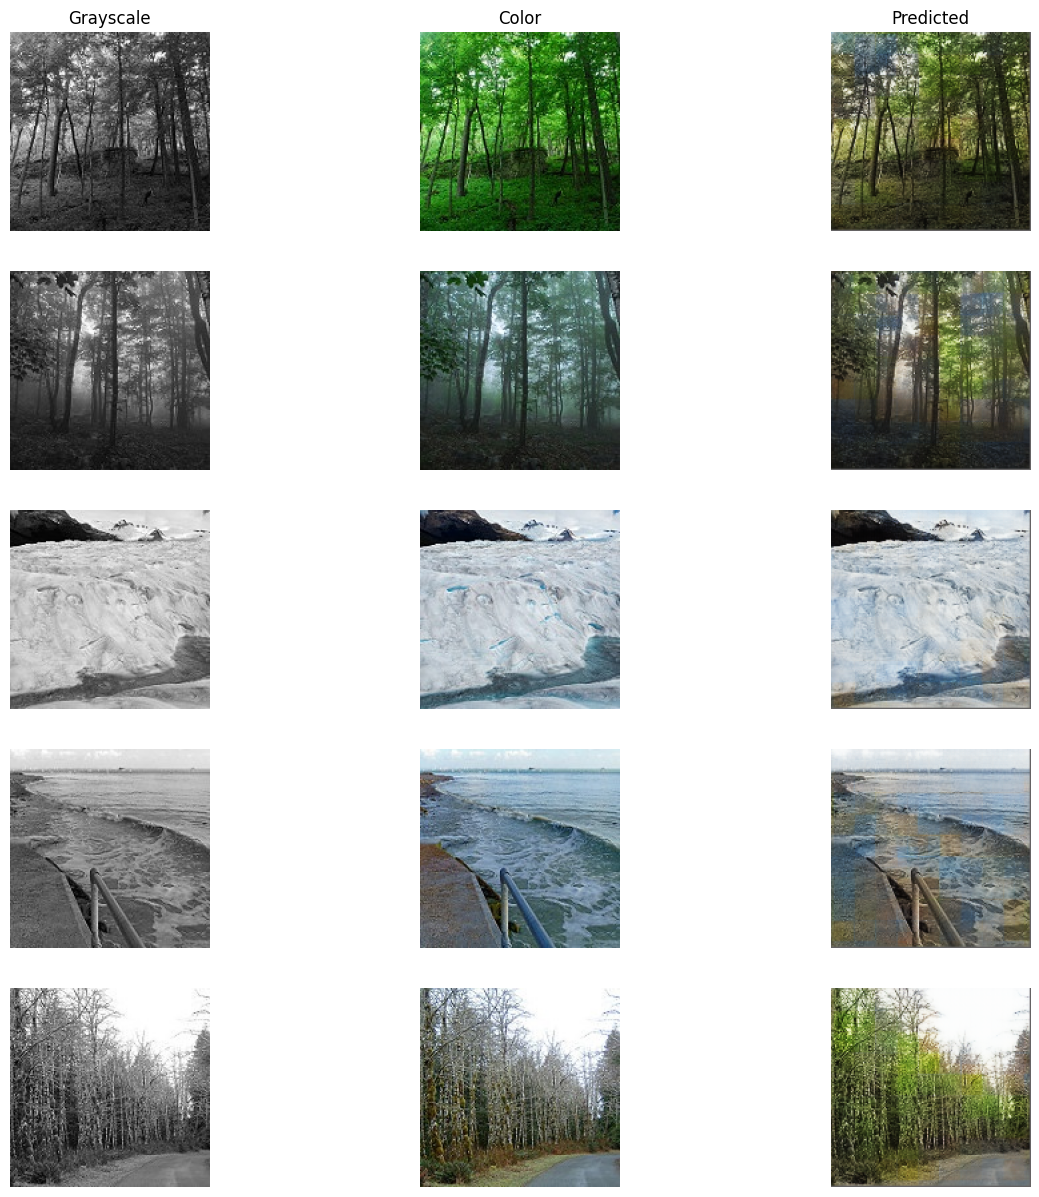

In [71]:
show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(), prediction.detach().cpu())


To Test single images

In [72]:
# gray_img = '/content/test_black.jpg'


In [73]:
IMAGE_SIZE = (150, 150)

In [74]:
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize(IMAGE_SIZE),  # Ensure consistent size
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert("RGB")  # Open as RGB first
    gray_image = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dim
    return gray_image, transforms.Resize(IMAGE_SIZE)(image)  # Return resized images

In [75]:
# Test a single image
def test_single_image(image_path, model):
    model.eval()

    gray_img, original_img = load_image(image_path)  # Load grayscale image

    with torch.no_grad():
        predicted_img = model(gray_img)  # Pass through model

    # Ensure same dimensions for visualization
    gray_np = gray_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    pred_np = predicted_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    orig_np = original_img

    # Plot results
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(gray_np, cmap="gray")
    axs[0].set_title("Grayscale Input")
    axs[0].axis("off")

    axs[1].imshow(orig_np)
    axs[1].set_title("Original Color Image")
    axs[1].axis("off")

    axs[2].imshow(pred_np)
    axs[2].set_title("Predicted Color Image")
    axs[2].axis("off")

    plt.show()

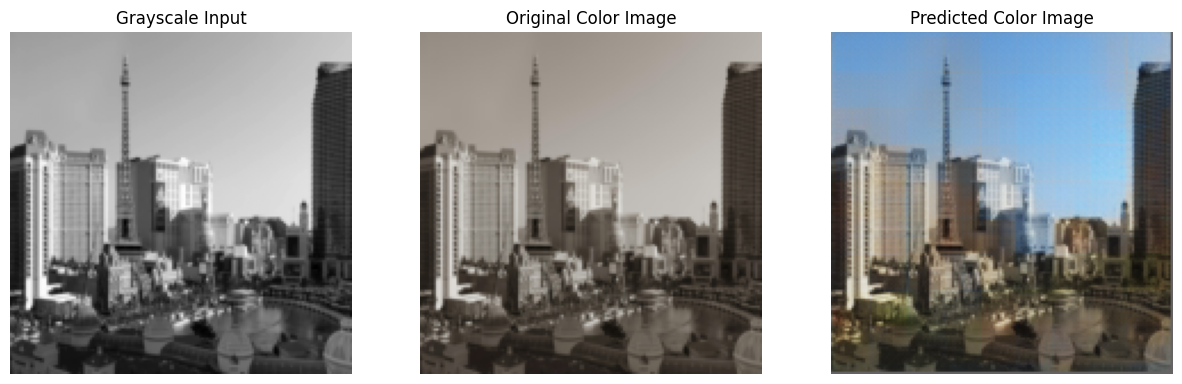

In [76]:
image_path = "/content/test_black.jpg"  # Change to your test image path
test_single_image(image_path, model)